In [37]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
from scipy.stats import linregress
from pytz import timezone
import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)

In [41]:
# load data
# Download data from Yahoo Finance
tickers = ["XLC", "XLY", "XLP", "XLE", "XLF", "XLV", "XLI", "XLB", "XLRE", "XLK", "XLU", "SPY"]

data_end_date = datetime.now() - timedelta(days = 1)
data_start_date = data_end_date - timedelta(days = 10 * 365)

folder = 'ProjectData'
if not os.path.exists(folder):
    os.mkdir(folder)

holder = {}
for ticker in tickers:

    file_name = f'{folder}/{ticker}.csv'
    if not os.path.exists(file_name):
        df = yf.Ticker(ticker).history(start = data_start_date.strftime("%Y-%m-%d"), end = data_end_date.strftime("%Y-%m-%d"))
        df.to_csv(file_name)

    df = pd.read_csv(file_name, index_col=0)
    df.index = pd.to_datetime(df.index, utc=True)
    df.index = df.index.tz_convert('US/Eastern')

    holder[ticker] = df

In [58]:
# Generate dfs with close prices, returns, and standardized returns
close_df = pd.concat(list(map(lambda x: x.Close, holder.values())), axis = 1)
close_df.columns = list(holder.keys())
open_df = pd.concat(list(map(lambda x: x.Open, holder.values())), axis = 1)
open_df.columns = list(holder.keys())
return_df = close_df.pct_change(axis = 0)
std_returns_df = (return_df - return_df.rolling(252, axis = 0).mean())/ return_df.rolling(252, axis = 0).std()
std_returns_df.dropna(inplace = True)


In [59]:
beta_df = pd.DataFrame()
benchmark_returns = return_df["SPY"]
for stock in return_df.columns:
    beta_df[stock] = return_df[stock].rolling(22).cov(benchmark_returns) / return_df[stock].rolling(22).var()
beta_df = beta_df.shift(1)

In [60]:
beta_df

,XLC,XLY,XLP,XLE,XLF,XLV,XLI,XLB,XLRE,XLK,XLU,SPY
Date,,,,,,,,,,,,
2014-05-09 00:00:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-05-12 00:00:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-05-13 00:00:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-05-14 00:00:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-05-15 00:00:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-29 00:00:00-04:00,0.446,0.714,0.492,0.282,0.533,0.712,0.842,0.605,0.375,0.619,0.198,1.000
2024-04-30 00:00:00-04:00,0.406,0.581,0.443,0.253,0.504,0.735,0.906,0.594,0.381,0.609,0.154,1.000
2024-05-01 00:00:00-04:00,0.439,0.591,0.511,0.353,0.581,0.715,0.919,0.653,0.425,0.623,0.196,1.000


In [61]:
from sklearn.decomposition import PCA
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

def get_residuals(data, N = 1):
    pca = PCA(n_components = N)
    pca.fit(data)
    index = pca.components_[0]
    mm = [sm.OLS(s, index).fit() for s in data.values]
    res = list(map(lambda x: x.resid.T, mm))
    return res

def z_score(data):
    scaler = StandardScaler()
    return scaler.fit_transform(data) 

In [69]:
def simulation(start_date, end_date, open_simu, close_simu, max_position, initial_cash, min_data_points, benchmark_data, beta_hedge):
    '''
    Simulation function

    Assume trades will be opened during daily open and closed during daily close
    '''
    entry = {}
    pnls = []
    betas = []
    orders = {}
    slippage = 0.00025
    commission_fee = 0.005
    beta_limit = 0

    tz = timezone('EST')
    start_date = start_date.replace(tzinfo = tz)
    end_date = end_date.replace(tzinfo = tz)

    if open_simu.shape != close_simu.shape:
        return

    if max_position >= close_simu.shape[1] / 2:
        print("There's too many positions within the portfolio")
        return

    cash_value = initial_cash
    for i in range(close_simu.shape[0] + 1):
        if close_simu.index[i] < start_date:
            continue

        if i < min_data_points:
            continue

        section_data = close_simu.iloc[i - min_data_points:i, :]
        if section_data.isna().sum().sum() > 0:
            continue

        # Getting residuals and z-scores based on previous close
        residuals = get_residuals(section_data, 2)
        residuals = np.stack(residuals, axis = 0)
        z_scores = z_score(residuals)
        zs = dict(enumerate(z_scores[-1, :], 1))

        # Get Mark-to-Market Value of different positions after previous close
        pnl = 0
        for stock, position_info in entry.items():
            price, size = position_info.values()
            if stock != "hedge":
                pnl += (price - close_simu.iloc[i - 1, stock]) * size
            else:
                pnl += (price - benchmark_data.Close[i - 1]) * size
            pnl -= commission_fee * abs(size)

        cash_value += pnl
        pnls.append(pnl)
        
        orders[close_simu.index[i - 1]] = entry
        
        if i >= close_simu.shape[0] or close_simu.index[i] > end_date:
            break


        # Opening the position according to open price of current time
        
        entry = {}
        idx_long = (np.argsort([zs[j] for j in zs])[:max_position])
        idx_short = (np.argsort([zs[j] for j in zs])[-max_position:])

        beta = 0
        
        for long, short in zip(idx_long, idx_short):
            long_entry_price = open_simu.iloc[i, long] * (1 + slippage)
            short_entry_price = open_simu.iloc[i, short] * (1 - slippage)
            entry[long] = {'price': long_entry_price, "size": np.round(cash_value / (max_position * long_entry_price))}
            entry[short] = {'price': short_entry_price, "size": - np.round(cash_value / (max_position * short_entry_price))}
            beta += (beta_df.iloc[i - 1, long] - beta_df.iloc[i - 1, short]) / max_position


        
        # Beta Hedge
        if beta_hedge and abs(beta) > beta_limit:
            abs_difference = abs(beta) - beta_limit
            hedge_direction = -1 if beta > 0 else 1
            entry_price = benchmark_data.Open[i] * (1 + slippage) if hedge_direction > 0 else benchmark_data.Open[i] * (1 - slippage)
            entry["hedge"] = {"price": entry_price, "size": np.round(abs_difference * cash_value / entry_price) * hedge_direction}
            beta += abs_difference * hedge_direction
        
        betas.append(beta)


    
    # Consolidate pnl data to df
    pnls = [0] * (min_data_points - 1) + pnls
    betas = [0] * (min_data_points) + betas
    pd.options.display.float_format = "{:.3f}".format
    df = pd.DataFrame(pnls, columns = ['daily_pnl'])
    df['ptf_value'] = initial_cash + df.daily_pnl.cumsum()
    df['ptf_beta'] = betas
    # df.index = close_simu[(close_simu.index >= start_date) & (close_simu.index <= end_date)].index

    return cash_value, df, orders




In [63]:
# Simulation setup
start_date = datetime(2019, 1, 1)
end_date = datetime(2024, 1, 1)
open_simu = open_df.drop(columns = ["SPY"])
close_simu = close_df.drop(columns = ["SPY"])
benchmark_data = holder["SPY"]
initial_cash = 10e5

In [70]:
max_position = 2
min_data_points = 170
end_cash_value, df, orders = simulation(start_date, end_date, open_simu, close_simu, max_position, initial_cash, min_data_points, benchmark_data, True)

,daily_pnl,ptf_value,ptf_beta
0,0.000,1000000.000,0.000
1,0.000,1000000.000,0.000
2,0.000,1000000.000,0.000
3,0.000,1000000.000,0.000
4,0.000,1000000.000,0.000
...,...,...,...
195,12080.181,1015897.147,0.000
196,-16631.825,999265.322,0.000
197,7335.083,1006600.406,0.000
198,9467.329,1016067.734,0.000


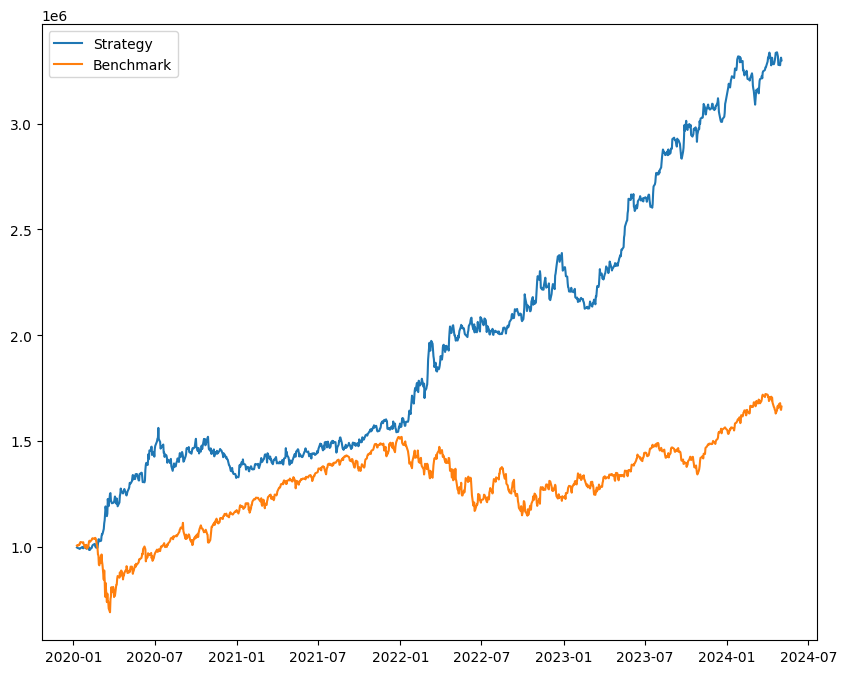

In [17]:
final_df = df.copy()
final_df['benchmark_close'] = close_df.SPY
final_df['benchmark_val'] = final_df.benchmark_close / final_df.benchmark_close[min_data_points - 1] * initial_cash
final_df['ptf_return'] = final_df.ptf_value.pct_change()
final_df['benchmark_return'] = final_df.benchmark_val.pct_change()
final_df = final_df[min_data_points:]

fig = plt.figure(figsize = (10, 8))
plt.plot(final_df.ptf_value, label = "Strategy")
plt.plot(final_df.benchmark_val, label = "Benchmark")
plt.legend()
plt.show()

In [18]:
ptf_returns = final_df.ptf_return.dropna()
benchmark_returns = final_df.benchmark_return.dropna()
model = sm.OLS(ptf_returns, sm.add_constant(benchmark_returns))
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             ptf_return   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     20.28
Date:                Tue, 07 May 2024   Prob (F-statistic):           7.42e-06
Time:                        03:03:01   Log-Likelihood:                 3458.0
No. Observations:                1086   AIC:                            -6912.
Df Residuals:                    1084   BIC:                            -6902.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0012      0.000      3.961      0.000       0.001       0.002
benchmark_return    -0.0989      0.022     -4.503      0.000      -0.142      -0.056
==============================================================================
Omnibus:                       76.816   Durbin-Watson:                   2.073
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              297.317
Skew:                           0.209   Prob(JB):                     2.74e-65
Kurtosis:                       5.529   Cond. No.                         72.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
from scipy.stats import norm
from prettytable import PrettyTable

# Descripitive Statistics
ptf_return = (final_df.ptf_value[-1] - final_df.ptf_value[0]) / final_df.ptf_value[0] * 100
avg_return = ptf_returns.mean()
std_daily_return = ptf_returns.std()
volatility = std_daily_return * np.sqrt(252)
confidence_level = 0.95
z_score_var = norm.ppf(confidence_level)
VaR_percentage = - z_score_var * std_daily_return
sharpe = avg_return / std_daily_return * np.sqrt(252)
window = 252
roll_max = final_df.ptf_value.rolling(window, min_periods = 1).max()
final_df['max_drawdown'] = final_df.ptf_value / roll_max - 1

# Display in table
table = PrettyTable()
table.field_names = ["Test Name", "Portfolio Return (%)", "Average Return (%)", "Volatility (%)", "VaR (%)", "MDD(%)", "Sharpe Ratio"]
stats = ["Backtest", ptf_return, avg_return * 100, volatility * 100, VaR_percentage * 100, -final_df.max_drawdown.min() * 100, sharpe]
table.add_row(stats)
print(table)

+-----------+----------------------+---------------------+--------------------+--------------------+--------------------+--------------------+
| Test Name | Portfolio Return (%) |  Average Return (%) |   Volatility (%)   |      VaR (%)       |       MDD(%)       |    Sharpe Ratio    |
+-----------+----------------------+---------------------+--------------------+--------------------+--------------------+--------------------+
|  Backtest |  230.75256170648876  | 0.11507510900267393 | 16.063464205862303 | -1.664432534400857 | 15.139409348389076 | 1.8052723308643959 |
+-----------+----------------------+---------------------+--------------------+--------------------+--------------------+--------------------+


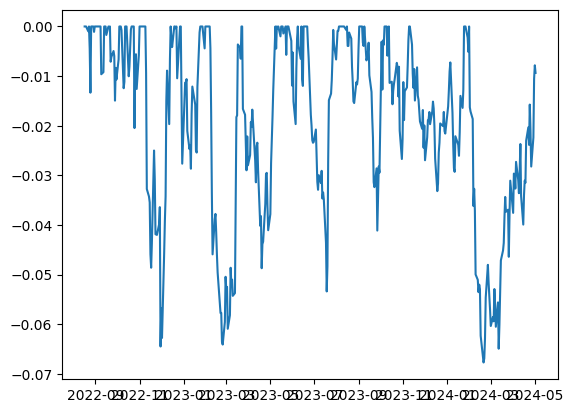

In [406]:
plt.plot(final_df.max_drawdown)

<Axes: >

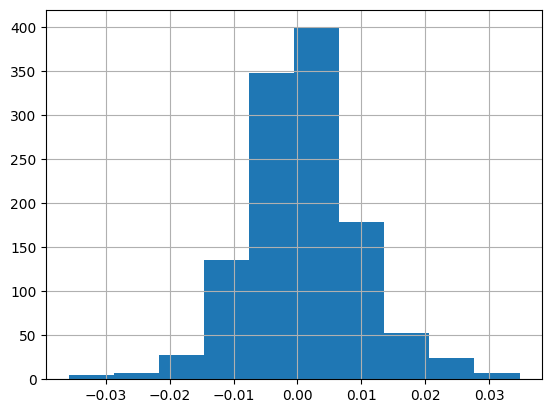

In [13]:
final_df.ptf_return.hist()

In [378]:
def cartesian(arrays, out=None):
    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    #m = n / arrays[0].size
    m = int(n / arrays[0].size)
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m, 1:])
        for j in range(1, arrays[0].size):
        #for j in xrange(1, arrays[0].size):
            out[j*m:(j+1)*m, 1:] = out[0:m, 1:]
    return out

# Optimization
import tqdm
end_cash_values = []
returns = []
max_pos_poss = list(range(1, 6))
min_points_poss = list(range(10, 252, 10))
all_possibilities = cartesian([max_pos_poss, min_points_poss])

for max_pos, min_point in tqdm.tqdm(all_possibilities):
    end_cash_value, final_df, orders = simulation(open_simu, close_simu, max_pos, initial_cash, min_point, benchmark_data,True)
    end_cash_values.append(end_cash_value)
    returns.append((end_cash_value - initial_cash) / initial_cash)

cdf = pd.DataFrame(zip(end_cash_values, returns), columns = ['final_cash_value', 'returns'])
cdf[["max_pos", "min_data_points"]] = all_possibilities
cdf.sort_values(by = "returns", ascending = False)

1000000.0